In [1]:
from metadrive.envs.metadrive_env import MetaDriveEnv
from metadrive.examples.ppo_expert.torch_expert import torch_expert as expert

from utils.scenario_runner import ScenarioRunner
from pathlib import Path
import numpy as np

In [2]:
def get_dt(fps):
    # Assume default value
    DECISION_REPEAT = 5
    interval = 1 / fps
    dt = interval / DECISION_REPEAT
    return dt


get_dt(30)

0.006666666666666666

In [3]:
import shutil

SAVE_DIR = Path("/media/olek/2TB_HDD/metadrive-data/sandbox")

# Remove all files in the directory
shutil.rmtree(SAVE_DIR) if SAVE_DIR.exists() else None

SAVE_DIR

PosixPath('/media/olek/2TB_HDD/metadrive-data/sandbox')

In [4]:
seed = 0

In [5]:
def get_env(fps):
    dt = get_dt(fps)
    sr = ScenarioRunner(SAVE_DIR, seed, dt=dt)
    config = sr.get_config()
    print(config)
    env = MetaDriveEnv(config)
    _, reset_info = env.reset()
    return env

In [6]:
def get_frames(fps):
    env = get_env(fps)
    frames = []
    for i in range(6000):
        action = expert(env.agent, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)

        frame = env.render(
            mode="topdown",
            window=False,
            screen_size=(1080 // 2, 1920 // 2),
            camera_position=(0, -200),
            scaling=2,
            draw_contour=True,
            num_stack=1,
            # screen_record=True,
        )
        frames.append(frame)
        if terminated or truncated:
            break
    env.close()
    return frames

In [7]:
frames_a = get_frames(10)
frames_b = get_frames(20)

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


{'log_level': 20, 'start_seed': 0, 'traffic_density': 0.1, 'traffic_mode': 'respawn', 'random_traffic': False, 'map_config': {'type': 'block_num', 'config': 5}, 'out_of_route_done': False, 'on_continuous_line_done': False, 'crash_vehicle_done': False, 'crash_object_done': False, 'crash_human_done': False, 'decision_repeat': 5, 'physics_world_step_size': 0.02}


[INFO] Use Torch PPO expert.
[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


{'log_level': 20, 'start_seed': 0, 'traffic_density': 0.1, 'traffic_mode': 'respawn', 'random_traffic': False, 'map_config': {'type': 'block_num', 'config': 5}, 'out_of_route_done': False, 'on_continuous_line_done': False, 'crash_vehicle_done': False, 'crash_object_done': False, 'crash_human_done': False, 'decision_repeat': 5, 'physics_world_step_size': 0.01}


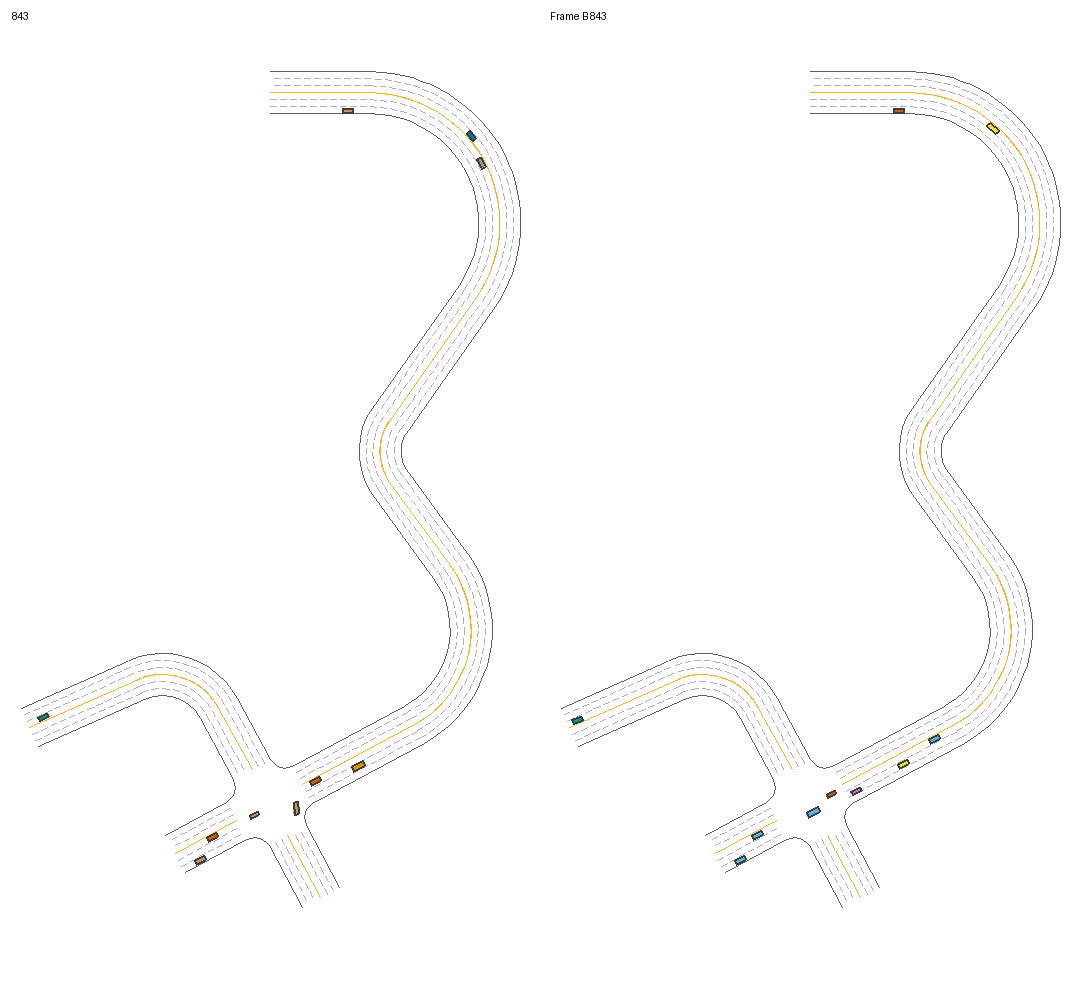

In [10]:
from PIL import Image, ImageDraw

import IPython.display as display

merged_images = []
for i, (a, b) in enumerate(zip(frames_a, frames_b[::2])):
    image_a = Image.fromarray(a)
    image_b = Image.fromarray(b)
    # Merge the two images side by side
    merged_image = Image.new("RGB", (image_a.width + image_b.width, image_a.height))

    merged_image.paste(image_a, (0, 0))
    merged_image.paste(image_b, (image_a.width, 0))

    merged_images.append(merged_image)
    # Display the merged image
    # Label the images
    label_a = Image.new("RGB", (image_a.width, 30), (255, 255, 255))
    label_b = Image.new("RGB", (image_b.width, 30), (255, 255, 255))
    draw_a = ImageDraw.Draw(label_a)
    draw_b = ImageDraw.Draw(label_b)
    draw_a.text((10, 10), f" {i}", fill=(0, 0, 0))
    draw_b.text((10, 10), f"Frame B {i}", fill=(0, 0, 0))

    # Combine labels with images
    combined_a = Image.new("RGB", (image_a.width, image_a.height + 30))
    combined_b = Image.new("RGB", (image_b.width, image_b.height + 30))
    combined_a.paste(label_a, (0, 0))
    combined_a.paste(image_a, (0, 30))
    combined_b.paste(label_b, (0, 0))
    combined_b.paste(image_b, (0, 30))

    # Merge the two labeled images side by side
    merged_image = Image.new("RGB", (combined_a.width + combined_b.width, combined_a.height))
    merged_image.paste(combined_a, (0, 0))
    merged_image.paste(combined_b, (combined_a.width, 0))

    merged_images.append(merged_image)
    display.display(merged_image, clear=True)